# GWAS / weaker signal simulation and colocboost

## Goal

This notebook simulates the cases that the first trait is treated as GWAS, or any other traits that have a weaker signals than the other traits (eg. eQTL). The first trait will be designed to have a less heritability.

## Input

`genofile`: plink file of real genotyope, `/mnt/vast/hpc/csg/FunGen_xQTL/ROSMAP/Genotype/plink_by_gene/extended_cis_before_winsorize_plink_files/*.bim`

The other parameters can be found in simxQTL repo. `https://github.com/StatFunGen/simxQTL`.

## Output

An rds matrix, with genotype matrix X (dimension: m * n, m: number of sample, n: number of SNP ) and phenotype (trait) matrix (dimension: m * a, m : number of samples, a: number of simulated traits) 

Example output:

In [41]:
result = readRDS("/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/simulation_signal_0.02/causal_1/sample_1_h2g_0.02_GWAS_1.rds")
result$variant

[[1]]
[1] 824

[[2]]
[1] 824

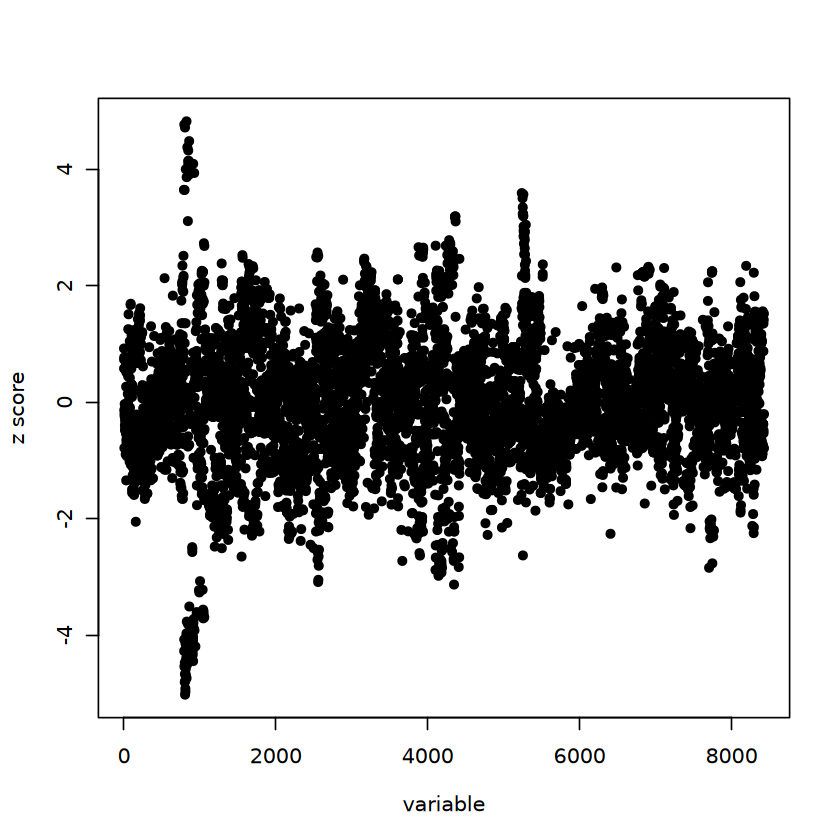

In [42]:
# Check their p values?
library(susieR)
par(family = "sans")
susie_res = susieR::susie(X = result$X, y = result$Y$Trait1, compute_univariate_zscore = TRUE)
susie_plot(susie_res, y = "z_original")

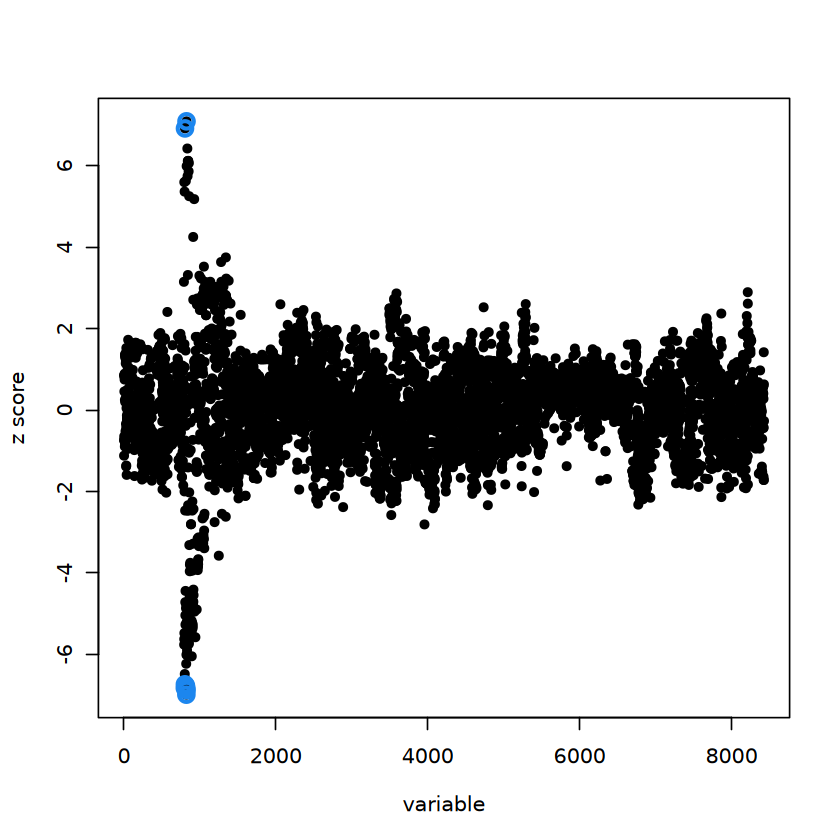

In [43]:
par(family = "sans")
susie_res = susieR::susie(X = result$X, y = result$Y$Trait2, compute_univariate_zscore = TRUE)
susie_plot(susie_res, y = "z_original")

In this case, the first trait (designed as GWAS) will not have fine-mapping CS result because of weak signal. 

In contrast, the second trait have a CS result.

## Phenotype simulation - 2 traits.

### Simulation code

In [ ]:
[simulation_GWAS]
parameter: genofile = paths
# pheno_file: give genotype file (in plink)，we can read the gentype matrix. These files are separated by TADs.
parameter: cwd = path("output")
parameter: job_size = 30
parameter: walltime = "100h"
parameter: mem = "30G"
parameter: numThreads = 1
# for each variant, how many traits it randomly colocalize at
parameter: ntrait = 2
parameter: h2g = 0.05
parameter: ncausal = 1
parameter: share_pattern = "all"
# specify the number of traits (phenotypes)
parameter: container = ""
parameter: independent = False
input: genofile, group_by = 1
output: f'{cwd:a}/sample_{_index}_h2g_{h2g}_GWAS_{ncausal}.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R:  expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container 
    library("MASS")
    library("plink2R")
    library("dplyr")
    library("readr")
    library("tidyverse")
    # source some functions to read matrix and inpute the missing data
    source("~/cloud_colocalization/simulation_code/simulate_linreg.R")
    source("~/cloud_colocalization/simulation_code/misc.R")
    # read the plink file
    simu_file = ${_input:r}
    geno <- read_plink(${_input:nr})
    gene_name = str_extract(simu_file, "ENSG[0-9]+")
    gene_tss_map = read_tsv("/home/hs3393/coloc/fungen-xqtl-analysis/resource/gene_cis_TADB_mapper.tsv")
    # filter by distance with. TSS
    TSS_pos = gene_tss_map$TSS[which(gene_tss_map$gene_id == gene_name)][1]
    keep_index = which(geno$bim$V4 > TSS_pos - 1500000 | geno$bim$V4 < TSS_pos + 1500000)
    geno$bed = geno$bed[,keep_index]
    # filter out columns with missing rate > 0.1
    imiss = 0.1
    # filter out columns with MAF < 0.05
    maf = 0.05
    Xmat = filter_X(geno$bed, imiss, maf)

    # To avoid that the matrix is too large, we use only the first 5000 SNPs in each TAD, if that region have more than 5,000 
    ncausal = ${ncausal}
    ntrait = ${ntrait}
    if (indep) {
        LD_vars = 1  # Initialize LD_vars

        if (ncausal == 1) {
            # If only one causal variant, just sample it
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Repeat sampling until selected variables are quasi independent
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)  
                cor_mat = cor(Xmat[, vars]) 
                LD_vars = which(colSums(abs(cor_mat) > 0.3) > 1)
            }
        }
    } else {
        vars = sample(1:ncol(Xmat), size = ncausal)
    }
    B = matrix(0, nrow =  ncol(Xmat), ncol = ntrait)
  
    
    phenotype = list()
    i = 1
    beta = sim_beta_fix_variant(G = Xmat, causal_index = vars, is_h2g_total = FALSE)
    B[, i] = beta
    pheno_single = sim_multi_traits(G = Xmat, B = B[,i, drop = FALSE], h2g = ${h2g}, is_h2g_total = FALSE)
    phenotype[[i]] = pheno_single$P
  
    i = 2
    beta = sim_beta_fix_variant(G = Xmat, causal_index = vars, is_h2g_total = FALSE)
    B[, i] = beta
  
    pheno_single = sim_multi_traits(G = Xmat, B = B[,i, drop = FALSE], h2g = 0.05, is_h2g_total = FALSE)
    phenotype[[i]] = pheno_single$P
  
    variant = list()
    for(i in 1:ncol(B)){
        variant[[i]] = which(B[,i] != 0)
    }
    X = Xmat
    Y = bind_cols(phenotype)
    colnames(Y) = paste0("Trait", c(1:ntrait))
    data = list()
    data[["X"]] = Xmat
    data[["Y"]] = Y
    data[["variant"]] = variant
    saveRDS(data, ${_output:r})

## Simulation GWAS - 5 traits

In [ ]:
[GWAS_5trait]
parameter: genofile = paths
# pheno_file: give genotype file (in plink)，we can read the gentype matrix. These files are separated by TADs.
parameter: cwd = path("output")
parameter: job_size = 30
parameter: walltime = "100h"
parameter: mem = "30G"
parameter: numThreads = 1
# specify the number of causal variants
parameter: n_trait = 5
parameter: n_causal = 1
parameter: h2g = 0.05
parameter: total_h2g = False
parameter: share_pattern = "all"
parameter: independent = False
# specify the number of traits (phenotypes)
parameter: container = ""
input: genofile, group_by = 1
output: f'{cwd:a}/{step_name}/sample_{_index}_real_simulation_{n_causal}_ncausal_{n_trait}_trait.rds'
R:  expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container 
    library("MASS")
    library("plink2R")
    library("dplyr")
    library("readr")
    library("tidyverse")
    # source some functions to read matrix and inpute the missing data
    source("~/cloud_colocalization/simulation_code/simulate_linreg.R")
    source("~/cloud_colocalization/simulation_code/misc.R")
    # read the plink file
    simu_file = ${_input:r}
    geno <- read_plink(${_input:nr})
    gene_name = str_extract(simu_file, "ENSG[0-9]+")
    gene_tss_map = read_tsv("/home/hs3393/coloc/fungen-xqtl-analysis/resource/gene_cis_TADB_mapper.tsv")
    # filter by distance with. TSS
    TSS_pos = gene_tss_map$TSS[which(gene_tss_map$gene_id == gene_name)][1]
    keep_index = which(geno$bim$V4 > TSS_pos - 1500000 | geno$bim$V4 < TSS_pos + 1500000)
    geno$bed <- geno$bed[, keep_index]

    # Filter out columns with missing rate > 0.1
    imiss <- 0.1

    # Filter out columns with MAF < 0.05
    maf <- 0.05

    # Apply filtering
    Xmat <- filter_X(geno$bed, imiss, maf)

    # Only keep the first 4000 variants
    ncausal <- ${n_causal}
    ntrait <- ${n_trait}
    indep = ${"TRUE" if independent else "FALSE"}

    if (indep) {
        LD_vars = 1  # Initialize LD_vars

        if (ncausal == 1) {
            # If only one causal variant, just sample it
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Repeat sampling until selected variables are quasi independent
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)  
                cor_mat = cor(Xmat[, vars]) 
                LD_vars = which(colSums(abs(cor_mat) > 0.3) > 1)
            }
        }
    } else {
        vars = sample(1:ncol(Xmat), size = ncausal)
    }
    # Load predefined proportions for causal variant sampling
    prop <- readRDS("/home/hs3393/cloud_colocalization/simulation_code/trait6_prop.rds")[, 1:4]
    proportions <- prop[ncausal, ]

    # Sample variant names based on predefined proportions
    sampled_name <- as.numeric(sample(names(proportions), size = ncausal, prob = proportions, replace = TRUE))

    # Initialize phenotype list and effect size matrix
    phenotype <- list()
    B <- matrix(0, nrow = ncol(Xmat), ncol = ntrait)

    # Configuration matrix for trait-variant relationships
    config <- matrix(0, nrow = ntrait, ncol = ncausal)

    # Assign causal variants to traits
    for (i in 1:ncausal) {
        coloc_trait <- sample(1:ntrait, sampled_name[i])
        config[coloc_trait, i] <- 1
    }

    # Simulate effect sizes and phenotypes
    for (i in 1:nrow(config)) {
        beta <- B[, i, drop = FALSE]
        index <- which(config[i, ] == 1)
  
        if(i == 1){
            h2g = ${h2g}
        }else{
            h2g = 0.05  
        }

        if (length(index) > 0) {
            causal_index <- vars[index]
            beta <- sim_beta_fix_variant(G = Xmat, causal_index = causal_index, is_h2g_total = FALSE)
            B[, i] <- beta
            pheno_single <- sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g, is_h2g_total = FALSE)
            phenotype[[i]] <- pheno_single$P
        } else {
            pheno_single <- sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g, is_h2g_total = FALSE)
            phenotype[[i]] <- pheno_single$P
        }
    }

    # Identify causal variants for each trait
    variant <- list()
    for (i in 1:ncol(B)) {
        variant[[i]] <- which(B[, i] != 0)
    }

    # Combine phenotype data
    X <- Xmat
    Y <- bind_cols(phenotype)
    colnames(Y) <- paste0("Trait", 1:ntrait)

    # Store results in a list
    data <- list()
    data[["X"]] <- Xmat
    data[["Y"]] <- Y
    data[["variant"]] <- variant

    # Save results
    saveRDS(data, ${_output:r})

## Simulation GWAS - 10 traits

In [ ]:
[GWAS_10trait]
parameter: genofile = paths
# pheno_file: give genotype file (in plink)，we can read the gentype matrix. These files are separated by TADs.
parameter: cwd = path("output")
parameter: job_size = 30
parameter: walltime = "100h"
parameter: mem = "30G"
parameter: numThreads = 1
# specify the number of causal variants
parameter: n_trait = 10
parameter: n_causal = 1
parameter: h2g = 0.05
parameter: total_h2g = False
parameter: independent = False
parameter: share_pattern = "all"
# specify the number of traits (phenotypes)
parameter: container = ""
input: genofile, group_by = 1
output: f'{cwd:a}/{step_name}/sample_{_index}_real_simulation_{n_causal}_ncausal_{n_trait}_trait.rds'
R:  expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container 
    library("MASS")
    library("plink2R")
    library("dplyr")
    library("readr")
    library("tidyverse")
    # source some functions to read matrix and inpute the missing data
    source("~/cloud_colocalization/simulation_code/simulate_linreg.R")
    source("~/cloud_colocalization/simulation_code/misc.R")
    # read the plink file
    simu_file = ${_input:r}
    geno <- read_plink(${_input:nr})
    gene_name = str_extract(simu_file, "ENSG[0-9]+")
    gene_tss_map = read_tsv("/home/hs3393/coloc/fungen-xqtl-analysis/resource/gene_cis_TADB_mapper.tsv")
    # filter by distance with. TSS
    TSS_pos = gene_tss_map$TSS[which(gene_tss_map$gene_id == gene_name)][1]
    keep_index = which(geno$bim$V4 > TSS_pos - 1500000 | geno$bim$V4 < TSS_pos + 1500000)
    geno$bed = geno$bed[,keep_index]
    # filter out columns with missing rate > 0.1
    imiss = 0.1
    # filter out columns with MAF < 0.05
    maf = 0.05
    Xmat = filter_X(geno$bed, imiss, maf)
    # only keep the first 4000 variants
    ncausal = ${n_causal}
    ntrait = ${n_trait}
    indep = ${"TRUE" if independent else "FALSE"}
    if (indep) {
        LD_vars = 1  # Initialize LD_vars

        if (ncausal == 1) {
            # If only one causal variant, just sample it
            vars = sample(1:ncol(Xmat), size = ncausal)
        } else {
            # Repeat sampling until selected variables are quasi independent
            while (length(LD_vars != 0)) {
                vars = sample(1:ncol(Xmat), size = ncausal)  
                cor_mat = cor(Xmat[, vars]) 
                LD_vars = which(colSums(abs(cor_mat) > 0.3) > 1)
            }
        }
    } else {
        vars = sample(1:ncol(Xmat), size = ncausal)
    }
  
    prop = readRDS("/home/hs3393/cloud_colocalization/simulation_code/trait10_prop.rds")
    proportions = prop[ncausal,]
    sampled_name <- as.numeric(sample(names(proportions), size =  ncausal, prob = proportions, replace = TRUE))
    phenotype = list()
    B = matrix(0, nrow =  ncol(Xmat), ncol = ntrait)
    config = matrix(0, nrow =  ntrait, ncol = ncausal)
    for(i in c(1:ncausal)){
          coloc_trait = sample(c(1:ntrait), sampled_name[i])
          config[coloc_trait, i] = 1
    }
    for(i in 1:nrow(config)){
        beta = B[,i, drop = FALSE]
        index = which(config[i,] == 1)
        if(i == 1){
            h2g = ${h2g}
        }else{
            h2g = 0.05  
        }
        if(length(index) > 0){
            causal_index = vars[index]
            beta = sim_beta_fix_variant(G = Xmat, causal_index = causal_index, is_h2g_total = FALSE)
            B[, i] = beta
            pheno_single = sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g, is_h2g_total = FALSE)
            phenotype[[i]] = pheno_single$P
        }else{
            pheno_single = sim_multi_traits(G = Xmat, B = as.matrix(beta), h2g = h2g, is_h2g_total = FALSE)
            phenotype[[i]] = pheno_single$P
        
        }
    }
    variant = list()
    for(i in 1:ncol(B)){
        variant[[i]] = which(B[,i] != 0)
    }
    X = Xmat
    Y = bind_cols(phenotype)
    colnames(Y) = paste0("Trait", c(1:ntrait))
    data = list()
    data[["X"]] = Xmat
    data[["Y"]] = Y
    data[["variant"]] = variant
    saveRDS(data, ${_output:r})

### Bash submission

In [ ]:
work_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/"
job="simulation_GWAS"
mkdir -p ${work_dir}
mkdir -p ${work_dir}/code
mkdir -p ${work_dir}/log
cd ${work_dir}/code

# Create the base_script file and write the bash code into it
cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 30:00:00
#SBATCH --mem=30000
#SBATCH -J GWAS_simu
#SBATCH -o WORK_DIR/log/JOB."%j".out
#SBATCH -e WORK_DIR/log/JOB."%j".err

source ~/mamba_activate.sh
module load Singularity


sos run /home/hs3393/cb_Mar/simulation_code/6.Simulation_GWAS.ipynb JOB \
    --genofile `ls /home/hs3393/cloud_colocalization/simulation_data/selected_genes_genotype/*.bim` \
    --mem 30G --h2g H2G --ncausal VAR --n_trait 2 --independent \
    --cwd WORK_DIR/simulation_signal_H2G/causal_VAR
EOF

base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.01 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

In [ ]:
work_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/GWAS_5trait/"
job="GWAS_5trait"
mkdir -p ${work_dir}
mkdir -p ${work_dir}/code
mkdir -p ${work_dir}/log
cd ${work_dir}/code

# Create the base_script file and write the bash code into it
cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 30:00:00
#SBATCH --mem=30000
#SBATCH -J GWAS_simu
#SBATCH -o WORK_DIR/log/JOB."%j".out
#SBATCH -e WORK_DIR/log/JOB."%j".err

source ~/mamba_activate.sh
module load Singularity


sos run /home/hs3393/cb_Mar/simulation_code/6.Simulation_GWAS.ipynb JOB \
    --genofile `ls /home/hs3393/cloud_colocalization/simulation_data/selected_genes_genotype/*.bim` \
    --mem 30G --h2g H2G --ncausal VAR --n_trait 5 --independent \
    --cwd WORK_DIR/simulation_signal_H2G/causal_VAR
EOF

base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

In [ ]:
work_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/GWAS_10trait/"
job="GWAS_10trait"
mkdir -p ${work_dir}
mkdir -p ${work_dir}/code
mkdir -p ${work_dir}/log
cd ${work_dir}/code

# Create the base_script file and write the bash code into it
cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 30:00:00
#SBATCH --mem=30000
#SBATCH -J GWAS_simu
#SBATCH -o WORK_DIR/log/JOB."%j".out
#SBATCH -e WORK_DIR/log/JOB."%j".err

source ~/mamba_activate.sh
module load Singularity


sos run /home/hs3393/cb_Mar/simulation_code/6.Simulation_GWAS.ipynb JOB \
    --genofile `ls /home/hs3393/cloud_colocalization/simulation_data/selected_genes_genotype/*.bim` \
    --mem 30G --h2g H2G --ncausal VAR --n_trait 10 --independent \
    --cwd WORK_DIR/simulation_signal_H2G/causal_VAR
EOF

base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

## Targeted Colocboost running

In [ ]:
[colocboost_target]
parameter: simufile = paths
parameter: cwd = path("output")
parameter: job_size = 15
parameter: walltime = "80h"
parameter: mem = "60G"
parameter: numThreads = 3
parameter: trait = 10
parameter: container = ""
input: simufile, group_by = 1
output: f'{cwd:a}/{_input[0]:bn}_ntrait_{trait}_{step_name}.rds'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R:  expand = '${ }', stdout = f"{_output:n}.stdout", stderr = f"{_output:n}.stderr", container = container 
    for(file in list.files("/home/xc2270/COLOCBoost/code_COLOCBoost/colocboost_updating/", full.names = T)) {source(file)}
    X = list()
    Y = list()
    variant = list()
    rds = readRDS(${_input:ar})

    for(i in 1:${trait}){
      X[[i]] = rds$X
      Y[[i]] = as.matrix(rds$Y[, i, drop = FALSE])
      variant[[i]] = rds$variant[[i]]
    }

    start_time <- Sys.time()
    colocboost_result = colocboost(
      X = X, 
      Y = Y, target_outcome_idx=1
    )
    end_time <- Sys.time()

    # record true variant, analysed trait number and corresponding file name
    colocboost_result$var = variant
    colocboost_result$trait_num = ${trait}
    colocboost_result$file = "${_input[0]:a}"

    # In real setting (list: variant), show which snp appear in at least two traits
    all_var = unlist(variant)
    true_var = as.numeric(names(which(table(all_var) >= 2)))
    true_trait = list()

    # Iterate through the variant list to find which traits the true_var is colocalized on
    for (variant_index in 1:length(true_var)){
      temp_vec = c()
      for(i in 1:length(variant)){
        if(true_var[variant_index] %in% variant[[i]]){
          temp_vec = c(temp_vec, i)
        }
      }
      true_trait[[variant_index]] = temp_vec
    }

    library(stringr)
    coloc_trait = list()

    # if no coloc sets detected, assign coloc_trait as NULL as well
    if(length(colocboost_result$cos_details$cos$cos_index) == 0){
      coloc_trait = NULL  
    } else {
      for(i in 1:length(colocboost_result$cos_details$cos_outcomes$outcome_index)){
        coloc_trait[[i]] = colocboost_result$cos_details$cos_outcomes$outcome_index[[i]]
      }
    }

    colocboost_result$true_variant = true_var
    colocboost_result$true_trait = true_trait
    colocboost_result$coloc_set = colocboost_result$cos_details$cos$cos_index
    colocboost_result$coloc_trait = coloc_trait
    colocboost_result$time = end_time - start_time
    saveRDS(colocboost_result, ${_output:r})

### Bash job submission

In [ ]:
data_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/"
job="colocboost_target"
work_dir="/home/hs3393/cb_Mar/simulation_result/simulation_GWAS/"
#!/bin/bash

mkdir -p ${work_dir}/${job}/code
mkdir -p ${work_dir}/${job}/log
mkdir -p ${work_dir}/${job}/result

cd ${work_dir}/${job}/code

cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 100:00:00
#SBATCH --mem=30000
#SBATCH -J JOB
#SBATCH -o WORK_DIR/JOB/log/JOB.%j.out
#SBATCH -e WORK_DIR/JOB/log/JOB.%j.err

source /home/hs3393/mamba_activate.sh
module load Singularity

cd DATA_DIR/simulation_signal_H2G/causal_VAR

sos run /home/hs3393/cb_Mar/simulation_code/6.Simulation_GWAS.ipynb JOB \
    --simufile $(find -type f -name '*.rds') \
    --mem 30G --trait 2 \
    --cwd WORK_DIR/JOB/simulation_signal_H2G/causal_VAR
EOF


base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.01 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g"  | sed "s|DATA_DIR|${data_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

In [ ]:
data_dir="/home/hs3393/cb_Mar/simulation_data/simulation_GWAS/"
job="colocboost"
work_dir="/home/hs3393/cb_Mar/simulation_result/simulation_GWAS/"
#!/bin/bash

mkdir -p ${work_dir}/${job}/code
mkdir -p ${work_dir}/${job}/log
mkdir -p ${work_dir}/${job}/result

cd ${work_dir}/${job}/code

cat << 'EOF' > base_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 100:00:00
#SBATCH --mem=30000
#SBATCH -J JOB
#SBATCH -o WORK_DIR/JOB/log/JOB.%j.out
#SBATCH -e WORK_DIR/JOB/log/JOB.%j.err

source /home/hs3393/mamba_activate.sh
module load Singularity

cd DATA_DIR/simulation_signal_H2G/causal_VAR

sos run /home/hs3393/cb_Mar/simulation_code/2.Run_Colocboost.ipynb JOB \
    --simufile $(find -type f -name '*.rds') \
    --mem 30G --trait 2 \
    --cwd WORK_DIR/JOB/simulation_signal_H2G/causal_VAR
EOF


base_script="base_script"
for variant in 1 2 3; do
    for h2g in 0.02 0.03 0.04 0.05; do
        output_script="variant_${variant}_h2g_${h2g}.sh"
        cat ${base_script}|sed "s|H2G|${h2g}|g" | sed "s|VAR|${variant}|g" | sed "s|WORK_DIR|${work_dir}|g"  | sed "s|DATA_DIR|${data_dir}|g" |sed "s|JOB|${job}|g"  > ${output_script}
        sbatch ${output_script}
    done
done

### Result summary

In [ ]:
data_dir="/home/hs3393/cb_Mar/simulation_result/simulation_GWAS/colocboost_target/"
mkdir -p ${data_dir}/summary
cd ${data_dir}/summary

cat << 'EOF' > summary_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 8:00:00
#SBATCH --mem=30000
#SBATCH -J sum
#SBATCH -o DATA_DIR/log/summary."%j".out
#SBATCH -e DATA_DIR/log/summary."%j".err

source ~/mamba_activate.sh

sos run /home/hs3393/cb_Mar/simulation_code/4.Result_Summary.ipynb coloc_summary \
    --folder DATA_DIR/ \
    --cwd DATA_DIR/summary
EOF


base_script="summary_script"
output_script="summary.sh"
cat ${base_script}|  sed "s|DATA_DIR|${data_dir}|g"  > ${output_script}
sbatch ${output_script}

In [ ]:
data_dir="/home/hs3393/cb_Mar/simulation_result/simulation_GWAS/colocboost/"
mkdir -p ${data_dir}/summary
cd ${data_dir}/summary

cat << 'EOF' > summary_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 8:00:00
#SBATCH --mem=30000
#SBATCH -J sum
#SBATCH -o DATA_DIR/log/summary."%j".out
#SBATCH -e DATA_DIR/log/summary."%j".err

source ~/mamba_activate.sh

sos run /home/hs3393/cb_Mar/simulation_code/4.Result_Summary.ipynb coloc_summary \
    --folder DATA_DIR/ \
    --cwd DATA_DIR/summary
EOF


base_script="summary_script"
output_script="summary.sh"
cat ${base_script}|  sed "s|DATA_DIR|${data_dir}|g"  > ${output_script}
sbatch ${output_script}

In [ ]:
data_dir="/home/hs3393/cb_simulation/simulation_result/colocboost/simulation_GWAS_not_targeted/"
mkdir -p ${data_dir}/summary
cd ${data_dir}/summary

cat << 'EOF' > summary_script
#!/bin/bash -l
# NOTE the -l flag!
#
#SBATCH -t 8:00:00
#SBATCH --mem=30000
#SBATCH -J sum
#SBATCH -o DATA_DIR/log/summary."%j".out
#SBATCH -e DATA_DIR/log/summary."%j".err

source ~/mamba_activate.sh

sos run /home/hs3393/cb_Mar/simulation_code/4.Result_Summary.ipynb coloc_summary \
    --folder DATA_DIR/ \
    --cwd DATA_DIR/summary
EOF


base_script="summary_script"
output_script="summary.sh"
cat ${base_script}|  sed "s|DATA_DIR|${data_dir}|g"  > ${output_script}
sbatch ${output_script}